In [44]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time, os
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline

num_epochs = 100

log_interval = 1000

In [45]:
# GPU setup
use_cuda = torch.cuda.is_available()
print("Using {}".format('GPU' if use_cuda else 'CPU'))

Using GPU


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

(52, 32, 3)


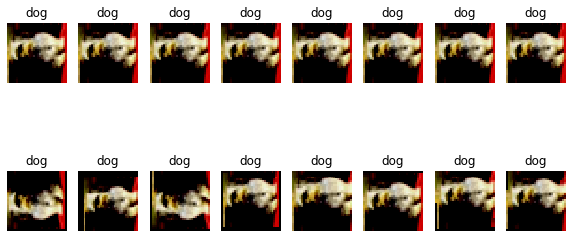

In [46]:
from torch.utils.data import Dataset

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def read_labels(label_file):
    labels = np.zeros(50000).astype(np.uint8)
    with open(label_file, 'r') as f:
        n, header_seen = 0, False
        for line in f:
            if not header_seen:
                header_seen = True
                continue
            labels[n] = int(line.strip().split(',')[1])
            n += 1
    return labels

train_labels = read_labels("dataset/train_labels.csv")

train_images = np.load("dataset/train_data.npy")

num_train = len(train_images)
indices = list(range(num_train))
split = 0

# shuffle data
np.random.seed(8256)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

transform = torchvision.transforms.Compose(
    [torchvision.transforms.Normalize((0.5,), (0.5,))])

class CIFAR10Dataset(Dataset):

    transform = transforms.Compose([
        #transforms.ToPILImage(),
        transforms.RandomAffine(0.5,translate=(0.05,0.05),scale=(0.9,1.1)),
        transforms.RandomHorizontalFlip()
        #transforms.RandomVerticalFlip()
        #transforms.ToTensor()
    ])    
    
    apply_transform=False
    
    def __init__(self, lbls, imgs):
        self.samples = [(torch.from_numpy(imgs[idx]),lbls[idx].item()) for idx in range(len(lbls))]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        
        res = []
        
        if self.apply_transform:
            res = self.transform(self.samples[idx][0])
            
            res = res + torch.normal(0, 255.0*0.0005, size=(3,32,32))
            
        else:
            res = self.samples[idx][0]
            
            
        return (res*2.0/255.0 - 1.0,self.samples[idx][1])
    

    

trainset_noxform = CIFAR10Dataset(train_labels,train_images)
trainset_noxform.apply_transform=False

trainset_xform = CIFAR10Dataset(train_labels,train_images)
trainset_xform.apply_transform=True

trainloader = torch.utils.data.DataLoader(trainset_xform, batch_size=25, sampler=train_sampler, shuffle=False)

validloader = torch.utils.data.DataLoader(trainset_noxform, batch_size=25, sampler=valid_sampler, shuffle=False)

plt.figure(1, figsize=(10,5))

print(np.transpose(torch.nn.functional.pad(trainset_noxform[0][0],(10,10), "reflect").numpy()).shape)

# No transform
for idx in range(8):
    plt.subplot(2,8,idx+1)
    plt.imshow(np.transpose(trainset_noxform[1][0].numpy()))
    plt.title("%s" % (class_names[train_labels[1]]))
    plt.axis('off')

# Transform
for idx in range(8):
    plt.subplot(2,8,idx+9)
    plt.imshow(np.transpose(trainset_xform[1][0].numpy()))
    plt.title("%s" % (class_names[train_labels[1]]))
    plt.axis('off')
    


In [47]:
np.any(trainset_noxform[0][0].numpy()>0)

True

In [48]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.conv1_bn = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 32, 5)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 8 * 8, 120)
        self.fc1_bn = nn.BatchNorm1d(120)        
        self.dropout1 = nn.Dropout(p=0.5)        
        self.fc2 = nn.Linear(120, 84)
        self.fc2_bn = nn.BatchNorm1d(84)
        self.dropout2 = nn.Dropout(p=0.5)        
        self.fc3 = nn.Linear(84, 84)
        self.fc3_bn = nn.BatchNorm1d(84)
        self.dropout3 = nn.Dropout(p=0.5)        
        self.fc4 = nn.Linear(84, 10)
        self.fc4_bn = nn.BatchNorm1d(10)
        self.dropout4 = nn.Dropout(p=0.5)        

        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = x.view(-1, 64 * 8 * 8)
        #x = self.dropout1(x)
        x = F.relu((self.fc1(x)))
        x = F.relu((self.fc2(x)))
        x = (self.fc3(x))
        x = ((self.fc4(x)))
        return x


#net = Net()

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam([var1, var2], lr=0.0001)

In [49]:
# https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
 #       self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

class ResNetEff(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNetEff, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.layer1 = self._make_layer(block, self.in_planes, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 16, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 16, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 16, num_blocks[3], stride=2)
        self.layer5 = self._make_layer(block, 32, num_blocks[4], stride=2)
        self.layer6 = self._make_layer(block, 64, num_blocks[5], stride=2)
        self.layer7 = self._make_layer(block, 128, num_blocks[6], stride=2)
        self.layer8 = self._make_layer(block, 128, num_blocks[7], stride=1)
        self.linear = nn.Linear(128*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        
        out = self.layer6(out)
        #print(out.shape)
        out = self.layer7(out)
        out = self.layer8(out)
        #print(out.shape)
        out = F.avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out    

def ResNetMake():
    return ResNetEff(BasicBlock, [2, 2, 2, 2, 2, 2, 2, 1])    
    
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())
    
    
net = ResNetMake()

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam([var1, var2], lr=0.0001)

In [50]:
training_acc_vect = np.zeros(num_epochs)
valid_acc_vect = np.zeros(num_epochs)

start_time = time.time()

# initialize weights and biases
#nn.init.kaiming_uniform_(net.conv1.weight, nonlinearity = 'relu')
#stdv = 1./np.sqrt(net.conv1.bias.size(0))
#nn.init.uniform_(net.conv1.bias, -stdv, stdv)
#nn.init.kaiming_uniform_(net.conv2.weight, nonlinearity = 'relu')
#stdv = 1./np.sqrt(net.conv2.bias.size(0))
#nn.init.uniform_(net.conv2.bias, -stdv, stdv)
#nn.init.kaiming_uniform_(net.conv3.weight, nonlinearity = 'relu')
#stdv = 1./np.sqrt(net.conv3.bias.size(0))
#nn.init.uniform_(net.conv3.bias, -stdv, stdv)
#nn.init.kaiming_uniform_(net.fc1.weight, nonlinearity = 'relu')
#stdv = 1./np.sqrt(net.fc1.bias.size(0))
#nn.init.uniform_(net.fc1.bias, -stdv, stdv)
#nn.init.kaiming_uniform_(net.fc2.weight, nonlinearity = 'relu')
#stdv = 1./np.sqrt(net.fc2.bias.size(0))
#nn.init.uniform_(net.fc2.bias, -stdv, stdv)
#nn.init.kaiming_uniform_(net.fc3.weight, nonlinearity = 'relu')
#stdv = 1./np.sqrt(net.fc3.bias.size(0))
#nn.init.uniform_(net.fc3.bias, -stdv, stdv)
#nn.init.kaiming_uniform_(net.fc4.weight, nonlinearity = 'relu')
#stdv = 1./np.sqrt(net.fc4.bias.size(0))
#nn.init.uniform_(net.fc4.bias, -stdv, stdv)

training_error_log = np.zeros(int(num_epochs*len(train_labels)/log_interval))
training_loss_log = np.zeros(int(num_epochs*len(train_labels)/log_interval))
valid_error_vect = np.zeros(num_epochs)

if use_cuda:
    net.cuda()
    criterion.cuda()

optimizer = optim.Adam(net.parameters() , lr=0.002) 
#optimizer = optim.SGD(net.parameters(), lr=0.0001,
#                      momentum=0.9, weight_decay=5e-4)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200) 
    
    
# train network
for epoch in range(num_epochs):  # loop over the dataset multiple times while training
    correct_train = 0
    total_train = 0
    correct_valid = 0    
    total_valid = 0
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data # list of [inputs, labels]
        
        #print(inputs.shape)
        
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()  
        
        #print(labels)
        optimizer.zero_grad() # clear gradients
        outputs = net(inputs) # forward step
        loss = criterion(outputs, labels)
        loss.backward() # backprop
        optimizer.step() # optimize weights

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        running_loss += loss.item()
        training_error = 1-correct_train/total_train
    
    
        if i % log_interval == log_interval-1:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f, training error: %.1f%%' % 
                  (epoch + 1, i + 1, running_loss / log_interval, training_error*100))
            training_loss_log[int((epoch*len(train_labels)/log_interval)+(i+1)/log_interval-1)] = running_loss/log_interval
            training_error_log[int((epoch*len(train_labels)/log_interval)+(i+1)/log_interval-1)] = training_error
            running_loss = 0.0    
    
    training_acc = correct_train / total_train * 100
    training_acc_vect[epoch] = training_acc
    
    for i, data in enumerate(validloader, 0):
        inputs, labels = data # list of [inputs, labels]   
        
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()        
        
        outputs = net(inputs) # forward step        

        _, predicted = torch.max(outputs.data, 1)
        total_valid += labels.size(0)    
        correct_valid += (predicted == labels).sum().item()        

        # print statistics
        duration = time.time() - start_time        
    
    if split > 0:
        valid_acc = correct_valid / total_valid * 100
    else:
        valid_acc = training_acc
    valid_acc_vect[epoch] = valid_acc    
    
    print('Accuracy  of the network on the 50000 training images after epoch %d: train: %.2f valid: %.2f %% (%.1f sec)' % (
        epoch + 1, training_acc, valid_acc, duration))
    
    # your code here to calculate the validation error after each epoch
    
print('Finished Training')

[1,  1000] loss: 1.956, training error: 72.0%
[1,  2000] loss: 1.653, training error: 66.6%
Accuracy  of the network on the 50000 training images after epoch 1: train: 33.36 valid: 33.36 % (1412.5 sec)
[2,  1000] loss: 1.501, training error: 54.6%
[2,  2000] loss: 1.378, training error: 52.0%
Accuracy  of the network on the 50000 training images after epoch 2: train: 47.96 valid: 47.96 % (1412.5 sec)
[3,  1000] loss: 1.270, training error: 45.8%
[3,  2000] loss: 1.198, training error: 44.2%
Accuracy  of the network on the 50000 training images after epoch 3: train: 55.78 valid: 55.78 % (1412.5 sec)
[4,  1000] loss: 1.119, training error: 40.0%
[4,  2000] loss: 1.075, training error: 39.2%
Accuracy  of the network on the 50000 training images after epoch 4: train: 60.82 valid: 60.82 % (1412.5 sec)
[5,  1000] loss: 1.020, training error: 36.0%
[5,  2000] loss: 0.994, training error: 35.6%
Accuracy  of the network on the 50000 training images after epoch 5: train: 64.40 valid: 64.40 % (14

KeyboardInterrupt: 

In [ ]:
epoch_vect = np.linspace(1, num_epochs, num_epochs)

plt.figure(1)
plt.plot(epoch_vect, 100-training_acc_vect)
plt.plot(epoch_vect, 100-valid_acc_vect)
plt.grid('on')
plt.xlabel('epoch')
plt.ylabel('% error')
plt.title('DNN error (train & valid)')
plt.legend(['train','valid'])

print("Final Accuracy: train: %g valid %g" % (training_acc, valid_acc))

# Your code here to plot validation error

## Test the network

In [ ]:
100.0-valid_acc

In [ ]:
MODELPATH = './cifar10_sample.pth.tar'
torch.save(net.state_dict(), MODELPATH)

In [ ]:
sum(p.numel() for p in net.parameters() if p.requires_grad)

## Estimate assignment grade on validation set

In [ ]:
network_complexity = {}
network_complexity['energy'] = 0.49993034 # Estimated energy in mJ.
network_complexity['latency'] = 0.06274400 # Number of cycles in Million (1e6).
network_complexity['activation'] = 131072 # Activation size in byte. 

In [ ]:
#accuracy = 1-valid_error_vect[-1]
def get_score(accuracy, network_complexity):
    error_rate = (1-accuracy) * 100
    #error_rate = 20
    print(str(error_rate))
    loss = error_rate / 12 + network_complexity['latency'] / 0.3
    
    if error_rate > 50:
        return (0, loss)
    elif network_complexity['activation'] > 1000000:
        return (0, loss)
    else:
        score = 0
        if network_complexity['energy'] > 2:
            score += 0
        elif network_complexity['energy'] > 1.5:
            score += 5
        elif network_complexity['energy'] > 1:
            score += 10
        elif network_complexity['energy'] > 0.5:
            score += 15
        else:
            score += 20
            
        if network_complexity['latency'] > 1:
            score += 0
        elif network_complexity['latency'] > 0.5:
            score += 5
        elif network_complexity['latency'] > 0.25:
            score += 10
        elif network_complexity['latency'] > 0.1:
            score += 15
        else:
            score += 20
            
        if error_rate < 5:
            score += 80
        elif error_rate < 10:
            score += 70
        elif error_rate < 20:
            score += 60
        elif error_rate < 30:
            score += 50
        elif error_rate < 40:
            score += 40
        else:
            score += 30
            
        return (score, loss)

base_score, loss = get_score(valid_acc/100.0, network_complexity)
    
# Calculated at the end of the competition based on everyones loss
competition_bonus = 0
final_score = base_score + (competition_bonus if base_score > 0 else 0)

print("Base Score: %d, Loss: %g" % (base_score, loss))
print("Final Score: %d" % (final_score))

In [51]:
import datetime

def create_submission(labels):
    now = time.time()
    now_str = datetime.datetime.fromtimestamp(now).strftime('%m%d-%H%M%S')
    complexity_str = '{:.4f}-{:.4f}-{}'.format(network_complexity['energy'], \
                                               network_complexity['latency'], \
                                               network_complexity['activation']).replace('.', 'p')
    filename = 'submission-%s-%s.csv' % (complexity_str, now_str)
    with open(filename, 'w') as f:
        f.write("Id,Prediction\n")
        for n in range(labels.shape[0]):
            f.write("%d,%d\n" % (n,labels[n]))
    return now_str, filename

test_images = np.load("dataset/test_data.npy")

# convert to torch format
test_images = torch.from_numpy(np.expand_dims(test_images, axis=1))
dummy_lbls = torch.zeros(test_images.shape[0])

print(test_images.shape) 

test_result = torch.zeros(test_images.shape[0])

bt_sz=25

print(test_images.shape[0]/bt_sz)

# test on validation data
with torch.no_grad():
    for i in range(int(test_images.shape[0]/bt_sz)):
        images = test_images[(i*bt_sz):(i*bt_sz + bt_sz)]
        images = (images/255.0)*2.0-1 # normalization [-1 to 1]
        images = images.float() # convert to torch format
        if use_cuda:
            images =images.cuda()
        #print(images.squeeze().shape)    
        outputs = net(images.squeeze())
        
        _, predicted = torch.max(outputs.data, 1)
        #print(str(predicted.cpu().numpy()))
        test_result[(i*bt_sz):(i*bt_sz + bt_sz)] = predicted
        #print((i*bt_sz) % 1000)
        if (i*bt_sz) % 5000 == 1000-bt_sz:
            print('Test data processed: %d/300000' % (i*bt_sz+bt_sz))

            
print("Writing file")
            
now_str, filename = create_submission(test_result.numpy())

torch.Size([300000, 1, 3, 32, 32])
12000.0
Test data processed: 1000/300000
Test data processed: 6000/300000
Test data processed: 11000/300000
Test data processed: 16000/300000
Test data processed: 21000/300000
Test data processed: 26000/300000
Test data processed: 31000/300000
Test data processed: 36000/300000
Test data processed: 41000/300000
Test data processed: 46000/300000
Test data processed: 51000/300000
Test data processed: 56000/300000
Test data processed: 61000/300000
Test data processed: 66000/300000
Test data processed: 71000/300000
Test data processed: 76000/300000
Test data processed: 81000/300000
Test data processed: 86000/300000
Test data processed: 91000/300000
Test data processed: 96000/300000
Test data processed: 101000/300000
Test data processed: 106000/300000
Test data processed: 111000/300000
Test data processed: 116000/300000
Test data processed: 121000/300000
Test data processed: 126000/300000
Test data processed: 131000/300000
Test data processed: 136000/300000

In [ ]:
print(len(valid_idx))